In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import jax
import numpy as np
from math import log, exp, sqrt
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# from estimate import posterior_decoding, sample_paths
from bmws.sim import sim_admix
from bmws.plotting import plot_summary, compute_rmse, bias_variance
from itertools import combinations_with_replacement, product

rng = np.random.default_rng()

N_SIMULATIONS = 10
N_EM_ITERATIONS = 3
set_matplotlib_formats("svg")

/tmp/ipykernel_629544/1919966932.py:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


<IPython.core.display.Javascript object>

## Simple model
Strong selection in one population, neutrality in others

In [3]:
T = 100  # number of time points
K = 3  # number of populations
d = 10  # sample every d generations
N = 100  # number of samples then

mdl = {
    "s": [[0.1] * (T - 1)] + [[0.0] * (T - 1)] * (K - 1),
    "h": [[0.5] * (T - 1)] * K,
    "f0": [0.1] * K,
}
mdl = {k: np.transpose(v) for k, v in mdl.items()}
rng = np.random.default_rng(1)
thetas = rng.dirichlet(np.ones(K), [T, N])  # admixture proportions
samples = np.zeros([T, N])
samples[::d] = 1

<IPython.core.display.Javascript object>

# One run

In [6]:
%%time
res = sim_admix(
    mdl,
    seed=1,
    thetas=thetas,
    samples=samples,
    M=100,
    estimate_kwargs={"lam": 1e4, "gamma": 0.0},
)

CPU times: user 6min 34s, sys: 1.28 s, total: 6min 35s
Wall time: 6min 32s


<IPython.core.display.Javascript object>

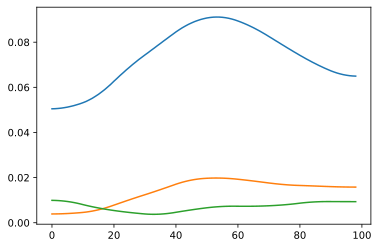

<IPython.core.display.Javascript object>

In [7]:
for s in res["s_hat"].T:
    plt.plot(s)

In [10]:
%%time
with ThreadPoolExecutor() as pool:
    futs = []
    for i in range(20):
        futs.append(
pool.submit(
        sim_admix,
        mdl,
        seed=i,
        thetas=thetas,
        samples=samples,
        M=100,
        estimate_kwargs={"lam": 1e4, "gamma": 0.0},
        ))
    res = [f.result() for f in futs]

CPU times: user 3h 20min 43s, sys: 31.1 s, total: 3h 21min 14s
Wall time: 14min 57s


<IPython.core.display.Javascript object>

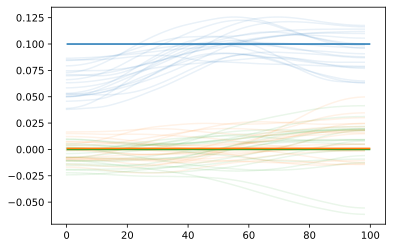

<IPython.core.display.Javascript object>

In [19]:
for r in res:
    plt.plot(r["s_hat"][:, 0], color="tab:blue", alpha=0.1)
    plt.plot(r["s_hat"][:, 1], color="tab:orange", alpha=0.1)
    plt.plot(r["s_hat"][:, 2], color="tab:green", alpha=0.1)

plt.hlines(0.1, 0, 100, color="tab:blue")

plt.hlines(0.0, 0, 100, color="tab:green")
plt.hlines(0.001, 0, 100, color="tab:orange")


## Performance if we incorrectly assume that Ne is constant 

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 9))

axs[0][0].axis("off")
optimal_lambda = [5, 4, 3]

for i in range(1, 3):
    axs[i][0].plot(range(1, 101), Ne_mdls[i], color="black")

for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

with ThreadPoolExecutor() as pool:
    for i in range(3):
        for j in range(1, 3):
            futs = [
                pool.submit(
                    sim_and_fit,
                    s_mdls[i],
                    seed=12345 + seed,
                    lam=10 ** optimal_lambda[i],
                    Ne=Ne_mdls[j],
                    Ne_fit=[10000] * len(s_mdls[i]["s"]),
                    em_iterations=N_EM_ITERATIONS,
                )
                for seed in range(N_SIMULATIONS)
            ]
            res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
            plot_summary(axs[j][i + 1], x, y, s_mdls[i]["s"])

## See how RMSE changes as sample size and frequency change

In [ ]:
ns = [1, 10, 100]
ks = [5, 10, 20]
size_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
optimal_lambda = [5, 4, 3]

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")


with ThreadPoolExecutor() as pool:
    for i, j in product(range(3), range(3)):
        plot_res = []  # results to make this subplot
        futs = [
            (
                nn,
                kk,
                seed,
                pool.submit(
                    sim_and_fit,
                    s_mdls[j],
                    seed=12345 + seed,
                    lam=10 ** optimal_lambda[j],
                    Ne=Ne_mdls[i],
                    n=nn,
                    k=kk,
                    em_iterations=N_EM_ITERATIONS,
                ),
            )
            for nn, kk, seed in product(ns, ks, range(N_SIMULATIONS))
        ]
        for nn, kk, seed, f in futs:
            this_res = f.result()
            rmse = compute_rmse(this_res["s_hat"], s_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": Ne_names[j],
                    "iter": seed,
                    "sampling": str(nn) + "-" + str(kk),
                    "rmse": rmse,
                }
            )

        size_res.extend(plot_res)
        plot_res = pd.DataFrame(plot_res)
        axs[i + 1][j + 1].tick_params(labelsize=6)
        axs[i + 1][j + 1].xaxis.label.set_visible(False)
        axs[i + 1][j + 1].title.set_visible(False)
        plot_res.boxplot(ax=axs[i + 1][j + 1], by="sampling", column=["rmse"])

fig.suptitle(None)
size_res = pd.DataFrame(size_res)

## Smoothing parameter

In [ ]:
log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
lam_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

lam_res = []
with ThreadPoolExecutor() as pool:
    for i, j in product(range(3), range(3)):
        plot_res = []  # results to make this subplot
        for lam in log10_lambda:
            futs = [
                pool.submit(
                    sim_and_fit,
                    s_mdls[j],
                    seed=12345 + seed,
                    lam=10 ** lam,
                    Ne=Ne_mdls[i],
                    em_iterations=N_EM_ITERATIONS,
                )
                for seed in range(N_SIMULATIONS)
            ]
            this_res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
            b, v, m = bias_variance(y, s_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": Ne_names[j],
                    "lambda": lam,
                    "rmse": m,
                    "rbias": b,
                    "rvar": v,
                }
            )

        lam_res.extend(plot_res)
        plot_res = pd.DataFrame(plot_res)
        axs[i + 1][j + 1].tick_params(labelsize=6)
        axs[i + 1][j + 1].xaxis.label.set_visible(False)
        axs[i + 1][j + 1].title.set_visible(False)
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
lam_res = pd.DataFrame(lam_res)

## Simulations using the sampling distribution of the ancient European samples

In [ ]:
samples = pd.read_csv("allbrit.meta", sep="\t")
samples["GenBP"] = samples.DateBP // 29  # assume 29 years per-generation
counts = samples.GenBP.value_counts().sort_index()
sizes, times = counts.values, np.array(counts.index)

T = times[-1]
s2_mdls = [
    {"s": [0.01] * T, "h": [0.5] * T, "f0": 0.1},
    {
        "s": [0.02 * np.cos(np.pi * x / (T - 1)) for x in range(T)],
        "h": [0.5] * T,
        "f0": 0.1,
    },
    {"s": (([0.02] * 20 + [-0.02] * 20) * 6)[:T], "h": [0.5] * T, "f0": 0.5},
]
gr = exp(log(100) / T)
Ne_mdl2 = [round(10000 * gr ** (10 * int(x / 10))) for x in range(T)]  # exp growth

In [ ]:
fig, axs = plt.subplots(
    ncols=3, nrows=2, figsize=(12, 6))

optimal_lambda = [5, 4, 2]


with ThreadPoolExecutor() as pool:
    for j in range(3):
        futs = [pool.submit(
            sim_and_fit,
            s2_mdls[j], seed=12345 + seed, lam=10**optimal_lambda[j], Ne=Ne_mdl2, k=times, n=sizes)
                for seed in range(N_SIMULATIONS)
               ]
        res = [f.result() for f in futs]    
        x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
        plot_summary(axs[0][j], x, y, s2_mdls[j]["s"])

    log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]

    for j in range(3):
        plot_res = []  # results to make this subplot
        for lam in log10_lambda:
            futs = [pool.submit(
                sim_and_fit,
                s2_mdls[j], seed=12345 + seed, lam=10 ** lam, Ne=10000, k=times, n=sizes,em_iterations=N_EM_ITERATIONS
            )
                    for seed in range(N_SIMULATIONS)
                   ]
            this_res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
            b, v, m = bias_variance(y, s2_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": "Exp2",
                    "lambda": lam,
                    "rmse": m,
                    "rbias": b,
                    "rvar": v,
                }
            )


    plot_res = pd.DataFrame(plot_res)
    axs[1][j].tick_params(labelsize=6)
    axs[1][j].xaxis.label.set_visible(False)
    axs[1][j].title.set_visible(False)
    axs[1][j].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
    axs[1][j].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
    axs[1][j].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
